# Set Up

In [117]:
# !pip install pyspark

In [118]:
import pyspark

In [119]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [120]:
from pyspark.sql.functions import to_date, col
from pyspark.sql.functions import to_date, dayofweek
from pyspark.sql.functions import mean, stddev
from pyspark.sql.functions import round
from pyspark.sql.functions import log
from pyspark.ml.feature import Binarizer
from pyspark.ml.feature import Bucketizer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import StringType, DateType
import seaborn as sns
import matplotlib.pyplot as plt

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Check Data

In [122]:
df = spark.read.csv('2017_StPaul_MN_Real_Estate.csv', inferSchema=True, header=True)

In [123]:
# convert all column names to uppercase
for col in df.columns:
  df = df.withColumnRenamed(col, col.upper())

In [124]:
# check schema
df.printSchema()

root
 |-- NO.: integer (nullable = true)
 |-- MLSID: string (nullable = true)
 |-- STREETNUMBERNUMERIC: integer (nullable = true)
 |-- STREETADDRESS: string (nullable = true)
 |-- STREETNAME: string (nullable = true)
 |-- POSTALCODE: integer (nullable = true)
 |-- STATEORPROVINCE: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- SALESCLOSEPRICE: integer (nullable = true)
 |-- LISTDATE: string (nullable = true)
 |-- LISTPRICE: integer (nullable = true)
 |-- LISTTYPE: string (nullable = true)
 |-- ORIGINALLISTPRICE: integer (nullable = true)
 |-- PRICEPERTSFT: double (nullable = true)
 |-- FOUNDATIONSIZE: integer (nullable = true)
 |-- FENCE: string (nullable = true)
 |-- MAPLETTER: string (nullable = true)
 |-- LOTSIZEDIMENSIONS: string (nullable = true)
 |-- SCHOOLDISTRICTNUMBER: string (nullable = true)
 |-- DAYSONMARKET: integer (nullable = true)
 |-- OFFMARKETDATE: string (nullable = true)
 |-- FIREPLACES: integer (nullable = true)
 |-- ROOMAREA4: string (nullable =

We see there's a problem with column 'No.', and columns that are supposed to be datetime are not datetime yet.

In [125]:
# Drop No. column
df = df.drop('NO.')

In [126]:
# Convert string column to date type using to_date with a format
df = df.withColumn("OFFMARKETDATE", to_date(df["OFFMARKETDATE"], "M/d/yyyy H:mm"))
df = df.withColumn("LISTDATE", to_date(df["LISTDATE"], "M/d/yyyy H:mm"))

Now check descriptive statistics.

In [127]:
# Descriptive Overview
df.describe().show()

+-------+-----+-------------------+-----------------+-------------+-----------------+---------------+----------------+------------------+------------------+-----------------+-----------------+------------------+----------------+--------------------+---------+------------------+--------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+------------------+---------------+------------------+--------------------+-----------------+-----------------+----------+------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------+--------------------+------------------+------------------+--------------------+----------------+--------------------+------------------+--------------------+----------+----------+-----------------+---------------------+-------------------+------------------+------------------+-------------------+------------------+-----+---------------

# EDA

## Analyze One Column

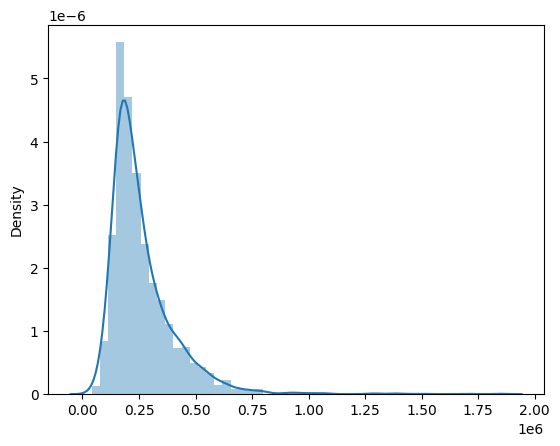

[Row(skewness(LISTPRICE)=2.790448093916559)]


In [128]:
# Select a single column and sample and convert to pandas
sample_df = df.select(['LISTPRICE']).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Plot distribution of pandas_df and display plot
sns.distplot(pandas_df)
plt.show()

# Import skewness function
from pyspark.sql.functions import skewness

# Compute and print skewness of LISTPRICE
print(df.agg({'LISTPRICE': 'skewness'}).collect())

## Analyze relationship between 2 columns

Creating linear model plots helps us visualize if variables have relationships with the dependent variable. If they do they are good candidates to include in our analysis. If they don't it doesn't mean that we should throw them out, it means we may have to process or wrangle them before they can be used.

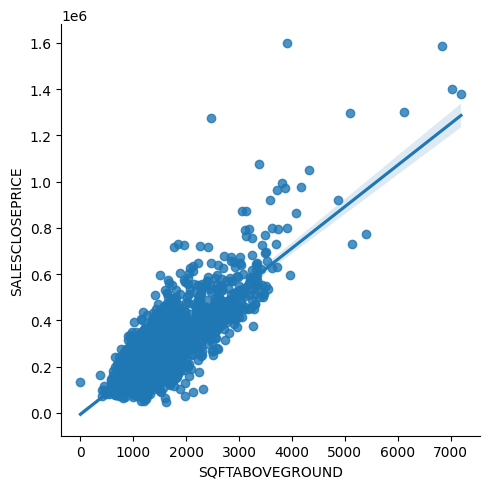

In [129]:
# Select columns
s_df = df.select(['SALESCLOSEPRICE', 'SQFTABOVEGROUND']) # Sample dataframe
s_df = s_df.sample(False, 0.5, 42)
# Convert to Pandas DataFrame
pandas_df = s_df.toPandas()
# Plot it
sns.lmplot(x='SQFTABOVEGROUND', y='SALESCLOSEPRICE', data=pandas_df)

# Clean Data

## Text Filtering

isin()  is similar to like() but allows us to pass a list of values to use as a filter rather than a single one.

In [130]:
df = df.where(~df['POTENTIALSHORTSALE'].like('Not Disclosed'))

In [131]:
# Inspect unique values in the column 'AssumableMortgage'
df.select(['AssumableMortgage']).distinct().show()

# List of possible values containing 'yes'
yes_values = ['Yes w/ Qualifying', 'Yes w/No Qualifying']

# Filter the text values out of df but keep null values
text_filter = ~df['AssumableMortgage'].isin(yes_values) | df['AssumableMortgage'].isNull()
df = df.where(text_filter)

# Print count of remaining records
print(df.count())

+-------------------+
|  AssumableMortgage|
+-------------------+
|  Yes w/ Qualifying|
| Information Coming|
|Yes w/No Qualifying|
|      Not Assumable|
|               NULL|
+-------------------+

4965


## Outlier Filtering

In [132]:
# Calculate values used for outlier filtering
mean_val = df.agg({'SalesClosePrice': 'mean'}).collect()[0][0]
stddev_val = df.agg({'SalesClosePrice': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['SalesClosePrice'] < hi_bound) & (df['SalesClosePrice'] > low_bound))

## Manage NAs

### Plotting Missing Values

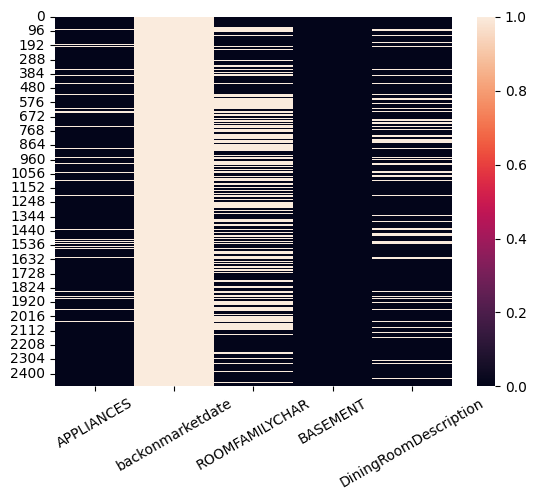

In [133]:
columns = ['APPLIANCES', 'backonmarketdate', 'ROOMFAMILYCHAR', 'BASEMENT', 'DiningRoomDescription']

# Sample the dataframe and convert to Pandas
sample_df = df.select(columns).sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

### Imputation of Missing Values

In [134]:
# Count missing rows
missing = df.where(df['DAYSONMARKET'].isNull()).count()

# Calculate the mean value
col_mean = df.agg({"DAYSONMARKET": 'mean'}).collect()[0][0]

# Replacing with the mean value for that column
df.fillna(col_mean, subset=['DAYSONMARKET'])

DataFrame[MLSID: string, STREETNUMBERNUMERIC: int, STREETADDRESS: string, STREETNAME: string, POSTALCODE: int, STATEORPROVINCE: string, CITY: string, SALESCLOSEPRICE: int, LISTDATE: date, LISTPRICE: int, LISTTYPE: string, ORIGINALLISTPRICE: int, PRICEPERTSFT: double, FOUNDATIONSIZE: int, FENCE: string, MAPLETTER: string, LOTSIZEDIMENSIONS: string, SCHOOLDISTRICTNUMBER: string, DAYSONMARKET: int, OFFMARKETDATE: date, FIREPLACES: int, ROOMAREA4: string, ROOMTYPE: string, ROOF: string, ROOMFLOOR4: string, POTENTIALSHORTSALE: string, POOLDESCRIPTION: string, PDOM: int, GARAGEDESCRIPTION: string, SQFTABOVEGROUND: int, TAXES: int, ROOMFLOOR1: string, ROOMAREA1: string, TAXWITHASSESSMENTS: double, TAXYEAR: int, LIVINGAREA: int, UNITNUMBER: string, YEARBUILT: int, ZONING: string, STYLE: string, ACRES: double, COOLINGDESCRIPTION: string, APPLIANCES: string, BACKONMARKETDATE: string, ROOMFAMILYCHAR: string, ROOMAREA3: string, EXTERIOR: string, ROOMFLOOR3: string, ROOMFLOOR2: string, ROOMAREA2: s

### Drop columns with more than 60% missing

In [135]:
def column_dropper(df, threshold):
    # Takes a dataframe and threshold for missing values. Returns a dataframe.
    total_records = df.count()
    for col in df.columns:
        # Calculate the percentage of missing values
        missing = df.where(df[col].isNull()).count()
        missing_percent = missing / total_records
        # Drop column if percent of missing is more than threshold
        if missing_percent > threshold:
            df = df.drop(col)
    return df

# Drop columns that are more than 60% missing
df = column_dropper(df, 0.6)

# Adjust Data

## Min-max Scaling

In [136]:
# Define max and min values and collect them
max_days = df.agg({'DAYSONMARKET': 'max'}).collect()[0][0]
min_days = df.agg({'DAYSONMARKET': 'min'}).collect()[0][0]

# Create a new column based off the scaled data
df = df.withColumn('percentage_scaled_days',
                  round((df['DAYSONMARKET'] - min_days) / (max_days - min_days)) * 100)

# Calc max and min for new column
print(df.agg({'percentage_scaled_days': 'max'}).collect())
print(df.agg({'percentage_scaled_days': 'min'}).collect())

[Row(max(percentage_scaled_days)=100.0)]
[Row(min(percentage_scaled_days)=0.0)]


In [137]:
cols_to_scale = ['FOUNDATIONSIZE', 'DAYSONMARKET', 'Fireplaces']

def min_max_scaler(df, cols_to_scale):
    # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
    for col in cols_to_scale:
        # Define min and max values and collect them
        max_days = df.agg({col: 'max'}).collect()[0][0]
        min_days = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        # Create a new column based off the scaled data
        df = df.withColumn(new_column_name, (df[col] - min_days) / (max_days - min_days))

    return df

df = min_max_scaler(df, cols_to_scale)
# Show that our data is now between 0 and 1
df[['DAYSONMARKET', 'scaled_DAYSONMARKET']].show()

+------------+--------------------+
|DAYSONMARKET| scaled_DAYSONMARKET|
+------------+--------------------+
|          10|0.044444444444444446|
|           4|0.017777777777777778|
|          28| 0.12444444444444444|
|          19| 0.08444444444444445|
|          21| 0.09333333333333334|
|          17| 0.07555555555555556|
|          32| 0.14222222222222222|
|           5|0.022222222222222223|
|          23| 0.10222222222222223|
|          73|  0.3244444444444444|
|          80| 0.35555555555555557|
|          79|  0.3511111111111111|
|          12| 0.05333333333333334|
|           1|0.004444444444444...|
|          18|                0.08|
|           2|0.008888888888888889|
|          12| 0.05333333333333334|
|          45|                 0.2|
|          31| 0.13777777777777778|
|          16| 0.07111111111111111|
+------------+--------------------+
only showing top 20 rows



## Standardization - Z transform

In [138]:
mean_days = df.agg({'DAYSONMARKET': 'mean'}).collect()[0][0]
stddev_days = df.agg({'DAYSONMARKET': 'stddev'}).collect()[0][0]
# Create a new column with the scaled data
df = df.withColumn("ztrans_days", (df['DAYSONMARKET'] - mean_days) / stddev_days)
df.agg({'ztrans_days': 'mean'}).collect()
df.agg({'ztrans_days': 'stddev'}).collect()

[Row(stddev(ztrans_days)=0.9999999999999986)]

## Log Scaling

In [139]:
# Compute the skewness
print(df.agg({'YEARBUILT': 'skewness'}).collect())

# Calculate the max year
max_year = df.agg({'YEARBUILT': 'max'}).collect()[0][0]

# Create a new column of reflected data
df = df.withColumn('Reflect_YearBuilt', (max_year + 1) - df['YEARBUILT'])

# Create a new column based reflected data
df = df.withColumn('adj_yearbuilt', 1 / log(df['Reflect_YearBuilt']))

[Row(skewness(YEARBUILT)=-0.2528853969865469)]


# Feature Engineering

## Create new columns

### Day of Week

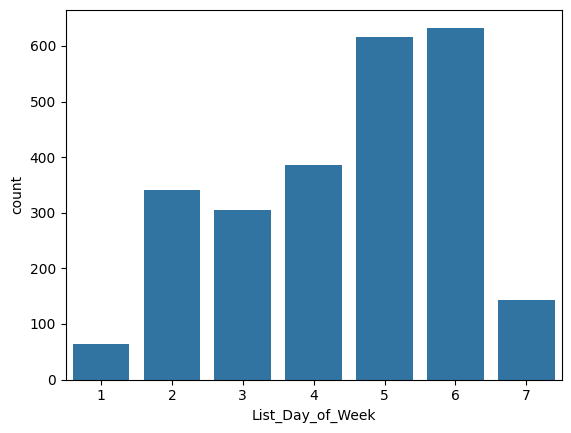

In [140]:
# Get the day of the week
df = df.withColumn('List_Day_of_Week', dayofweek('LISTDATE'))

# Sample and convert to pandas dataframe
sample_df = df.sample(False, 0.5, 42).toPandas()

# Plot count plot of of day of week
sns.countplot(x="List_Day_of_Week", data=sample_df)
plt.show()

### Size-related Columns

In [141]:
# Lot size in square feet
acres_to_sqfeet = 43560
df = df.withColumn('LOT_SIZE_SQFT', df['ACRES'] * acres_to_sqfeet)

# Create new column YARD_SIZE
df = df.withColumn('YARD_SIZE', df['LOT_SIZE_SQFT'] - df['FOUNDATIONSIZE'])

# Corr of ACRES vs SALESCLOSEPRICE
print("Corr of ACRES vs SALESCLOSEPRICE: " + str(df.corr('ACRES', 'SALESCLOSEPRICE')))
# Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE
print("Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: " + str(df.corr('FOUNDATIONSIZE', 'SALESCLOSEPRICE')))
# Corr of YARD_SIZE vs SALESCLOSEPRICE
print("Corr of YARD_SIZE vs SALESCLOSEPRICE: " + str(df.corr('YARD_SIZE', 'SALESCLOSEPRICE')))

Corr of ACRES vs SALESCLOSEPRICE: 0.2149274462815797
Corr of FOUNDATIONSIZE vs SALESCLOSEPRICE: 0.5670907346340114
Corr of YARD_SIZE vs SALESCLOSEPRICE: 0.20330952450143708


### Ratio-related Columns

In [142]:
# ASSESSED_TO_LIST
df = df.withColumn("ASSESSED_TO_LIST", df['ASSESSEDVALUATION']/df['LISTPRICE'])
df[['ASSESSEDVALUATION', 'LISTPRICE', 'ASSESSED_TO_LIST']].show(5)
# TAX_TO_LIST
df = df.withColumn("TAX_TO_LIST", df['TAXES']/df['LISTPRICE'])
df[['TAX_TO_LIST', 'TAXES', 'LISTPRICE']].show(5)
# BED_TO_BATHS
df = df.withColumn("BED_TO_BATHS", df['BEDROOMS']/df['BATHSTOTAL'])
df[['BED_TO_BATHS', 'BEDROOMS', 'BATHSTOTAL']].show(5)

+-----------------+---------+----------------+
|ASSESSEDVALUATION|LISTPRICE|ASSESSED_TO_LIST|
+-----------------+---------+----------------+
|              0.0|   139900|             0.0|
|              0.0|   210000|             0.0|
|              0.0|   225000|             0.0|
|              0.0|   230000|             0.0|
|              0.0|   239900|             0.0|
+-----------------+---------+----------------+
only showing top 5 rows

+--------------------+-----+---------+
|         TAX_TO_LIST|TAXES|LISTPRICE|
+--------------------+-----+---------+
|0.013280914939242315| 1858|   139900|
| 0.00780952380952381| 1640|   210000|
|0.010622222222222222| 2390|   225000|
|0.009330434782608695| 2146|   230000|
|0.008378491037932471| 2010|   239900|
+--------------------+-----+---------+
only showing top 5 rows

+------------------+--------+----------+
|      BED_TO_BATHS|BEDROOMS|BATHSTOTAL|
+------------------+--------+----------+
|               1.5|       3|         2|
|1.333333333

## Bucketing

In [143]:
splits = [0, 1, 2, 3, 4, float('Inf')]

# Create bucketing transformer
buck = Bucketizer(splits=splits, inputCol='BATHSTOTAL', outputCol='baths')

# Apply transformer
df = buck.transform(df)

# Inspect results
df[['BATHSTOTAL', 'baths']].show()

+----------+-----+
|BATHSTOTAL|baths|
+----------+-----+
|         2|  2.0|
|         3|  3.0|
|         1|  1.0|
|         2|  2.0|
|         2|  2.0|
|         2|  2.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
|         3|  3.0|
+----------+-----+
only showing top 20 rows



## One-hot Encoding

In [144]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# Map strings to numbers with string indexer
string_indexer = StringIndexer(inputCol='SCHOOLDISTRICTNUMBER', outputCol='School_Index')
indexed_df = string_indexer.fit(df).transform(df)

# Onehot encode indexed values
encoder = OneHotEncoder(inputCol='School_Index', outputCol='School_Vec')
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

# Inspect the transformation steps
encoded_df[['SCHOOLDISTRICTNUMBER', 'School_Index', 'School_Vec']].show(truncate=100)

+-----------------------------+------------+-------------+
|         SCHOOLDISTRICTNUMBER|School_Index|   School_Vec|
+-----------------------------+------------+-------------+
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(6,[1],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|622 - North St Paul-Maplewood|         1.0|(6,[1],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0])|
|             834 - Stillwater|         3.0|(6,[3],[1.0]

# Build Model

## Vectorize feature columns

In [145]:
# # Drop na
df = df.fillna(-1)

# Identify string columns
columns_to_drop = [field.name for field in df.schema.fields if isinstance(field.dataType, (StringType, DateType))]

# Drop string columns
df_no_strings = df.drop(*columns_to_drop)

# Define the columns to be converted to vectors
features_cols = list(df_no_strings.columns)

# Create the vector assembler transformer
vec = VectorAssembler(inputCols=features_cols, outputCol='features')

In [146]:
df = vec.transform(df)
df_ml = df.select(['SALESCLOSEPRICE', 'features'])
df_ml.show(5)

+---------------+--------------------+
|SALESCLOSEPRICE|            features|
+---------------+--------------------+
|         143000|[11511.0,55042.0,...|
|         190000|[11200.0,55042.0,...|
|         225000|[8583.0,55042.0,2...|
|         265000|[9350.0,55042.0,2...|
|         249900|[2915.0,55042.0,2...|
+---------------+--------------------+
only showing top 5 rows



## Building a Regression Model

In [147]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import mean, col

In [148]:
# Splitting the Data
trainDF, testDF = df_ml.randomSplit([0.7, 0.3], seed=42)

# Model Building
lr = LinearRegression(featuresCol="features", labelCol="SALESCLOSEPRICE")

# Train the model
model = lr.fit(trainDF)

# 7. Evaluation
predictions = model.transform(testDF)
evaluator = RegressionEvaluator(labelCol="SALESCLOSEPRICE", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {mae}")

# Show some predictions
predictions.select("prediction", "SALESCLOSEPRICE").show(5)

Root Mean Squared Error (RMSE) on test data = 5.184508662492999
+------------------+---------------+
|        prediction|SALESCLOSEPRICE|
+------------------+---------------+
| 50811.97176537725|          50800|
| 60004.66877075422|          60000|
|61007.203775073474|          61000|
| 62003.87254427494|          62000|
|  63008.6532369598|          63000|
+------------------+---------------+
only showing top 5 rows



## Evaluate result

In [149]:
# Select columns to compute test error
evaluator = RegressionEvaluator(labelCol="SALESCLOSEPRICE", predictionCol="prediction")

# Create evaluation metrics
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

# Print Model Metrics
print('MAE: ' + str(mae))

MAE: 5.184508662492999


In [151]:
df.select('SALESCLOSEPRICE').describe().show()

+-------+------------------+
|summary|   SALESCLOSEPRICE|
+-------+------------------+
|  count|              4886|
|   mean|252793.60049119935|
| stddev|112779.91029069609|
|    min|             48000|
|    max|            683000|
+-------+------------------+



In [ ]:
cư